#  1 visible the data and do preprocess
Always the first thing is to visible the data. I generate the data from the simulator, but I found that the dataset is too small, then I directly use data from udacity, the code is below

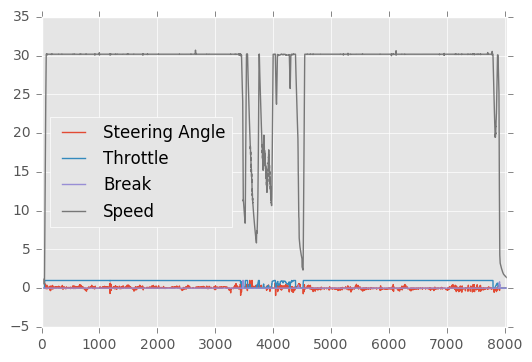

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#matplotlib.style.use('ggplot')
drivingLog = pd.read_csv('data/driving_log.csv',names=['Center','Left','Right','Steering Angle','Throttle','Break','Speed'],header=None)

plt.figure(figsize=(20,10));
drivingLog.plot();

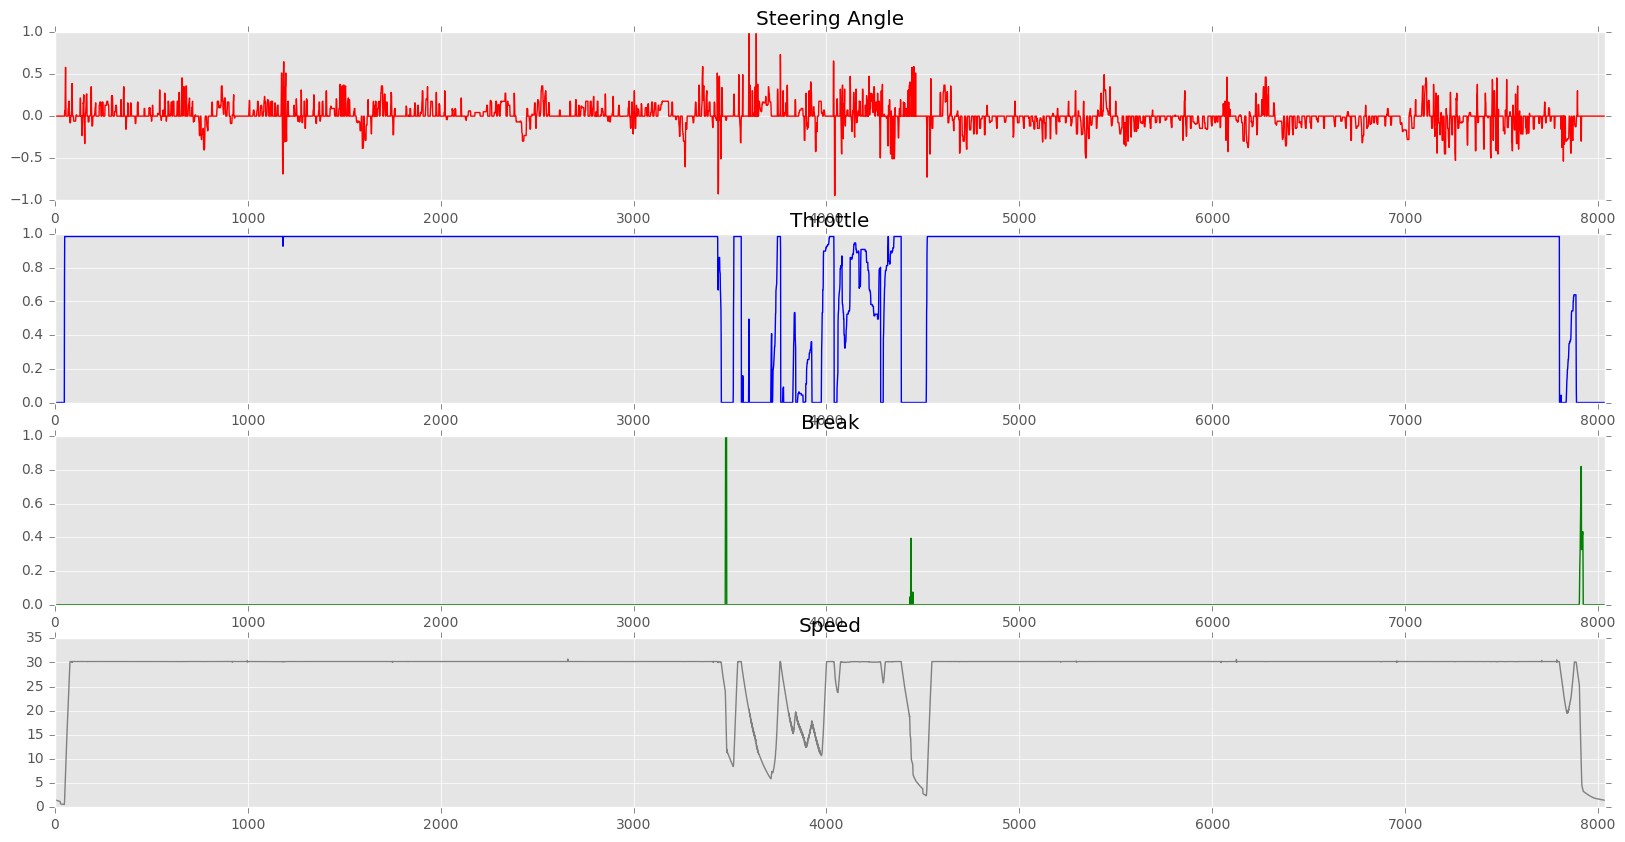

In [31]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(20,10))
drivingLog['Steering Angle'].plot(ax=axes[0],color='red'); axes[0].set_title('Steering Angle');
drivingLog['Throttle'].plot(ax=axes[1],color='blue'); axes[1].set_title('Throttle');
drivingLog['Break'].plot(ax=axes[2],color='green'); axes[2].set_title('Break');
drivingLog['Speed'].plot(ax=axes[3],color='gray'); axes[3].set_title('Speed');

It not clear, so I write some code to see the distrubition

In [ ]:
#read data from csv and show the angle distribution
class AngleNum(dict):
	def __missing__(self, key):
		return 0

angle_num = AngleNum()

#read data from csv,and count the angle num
with open('data/driving_log.csv') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
    	angle = round(float(row[3]),3)*100
    	angle_num[angle] = angle_num[angle]+1

        
labels=[]
label_num=[]

for (label, num) in angle_num.items():
    labels.append(label)
    label_num.append(num)

x_label = np.arange(-150,150,5)
y_label = np.arange(0,1000,100)
plt.xticks(x_label,x_label,ha='right',rotation=45)
plt.yticks(y_label,y_label)
plt.bar(labels,label_num)
plt.show()

the data distribution is like that  
<img src='http://7xj2gx.com1.z0.glb.clouddn.com/d2.png' width='50%'>  

so we have so much 0 degree, so I use some random to reduce the 0 degree

``
if angle==0:
    if random.random()<0.02:            
        im_center=crop_img(prefix+row[0].strip())
        x_train.append(np.array(im_center))
        y_train.append(angle)             
``

after that the distrubition is like that:

<img src='http://7xj2gx.com1.z0.glb.clouddn.com/d3.png' width='50%'>

then I run my CNN model,the car move success!But unfortunately the car stop in the black wall,like that  

<img src='http://7xj2gx.com1.z0.glb.clouddn.com/%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202017-02-19%20%E4%B8%8A%E5%8D%887.32.47.png' width='50%'>  

so I think maybe the edge is not clear in RGB model, so I transfer RGB to HSV, 

<code>
cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
</code>

then run the model again, that success! The car run farther, but the car run across shape corner in the pool, like that
<img src='http://7xj2gx.com1.z0.glb.clouddn.com/%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202017-02-19%20%E4%B8%8A%E5%8D%887.58.43.png' width='50%'>  
the image is not matched well, the car just run across this corner to the pool

then I think maybe I should add some data in the shape corner, so I use simulater to generator some data with shape corner, which store in my 'driving_log_20.csv', and the distribution is like that
<img src='http://7xj2gx.com1.z0.glb.clouddn.com/d1.png' width='50%'>  

then I combine the code in the below, I also add crop image and flip image, like that

In [71]:
import random
from PIL import Image
import csv
import numpy as np
import cv2

x_train =[]
y_train =[]

def crop_img(image_path):
    im = Image.open(image_path.strip())
    im = im.crop((0,im.size[1]/3,im.size[0],im.size[1]-25)) #crop the top 1/5 and the bottom 25 pix down
    return im

i=0
files=['data/driving_log.csv','driving_log_20.csv']
for file in files:
    with open(file) as csvfile:
        spamreader = csv.reader(csvfile)
        prefix=file[0:file.find('/')+1]
        for row in spamreader:
            angle = float(row[3].strip())
            if angle==0:
                if random.random()<0.02:            
                    i+=1
                    im_center=crop_img(prefix+row[0].strip())
                    x_train.append(np.array(im_center))
                    y_train.append(angle)

            else:

                #center image
                im_center=crop_img(prefix+row[0].strip())
                x_train.append(np.array(im_center))
                y_train.append(angle)

                #flip image and add

                imageFlipped = cv2.flip(np.array(im_center), 1)
                x_train.append(imageFlipped)
                y_train.append(-angle)

                #left image
                left_angle = angle+0.25
                im_left=crop_img(prefix+row[1].strip())
                x_train.append(np.array(im_left))
                y_train.append(left_angle)

                #flip image and add
                imageFlipped = cv2.flip(np.array(im_left), 1)
                x_train.append(imageFlipped)
                y_train.append(-left_angle)

                #right image
                right_angle = angle-0.25
                im_right=crop_img(prefix+row[2].strip())
                x_train.append(np.array(im_right))
                y_train.append(right_angle)

                #flip image and add
                imageFlipped = cv2.flip(np.array(im_right), 1)
                x_train.append(imageFlipped)
                y_train.append(-right_angle)
                      

print('loading data finished')
print(i,len(y_train))

loading data finished
712 67666


## resize the image, change to HSV and show some img

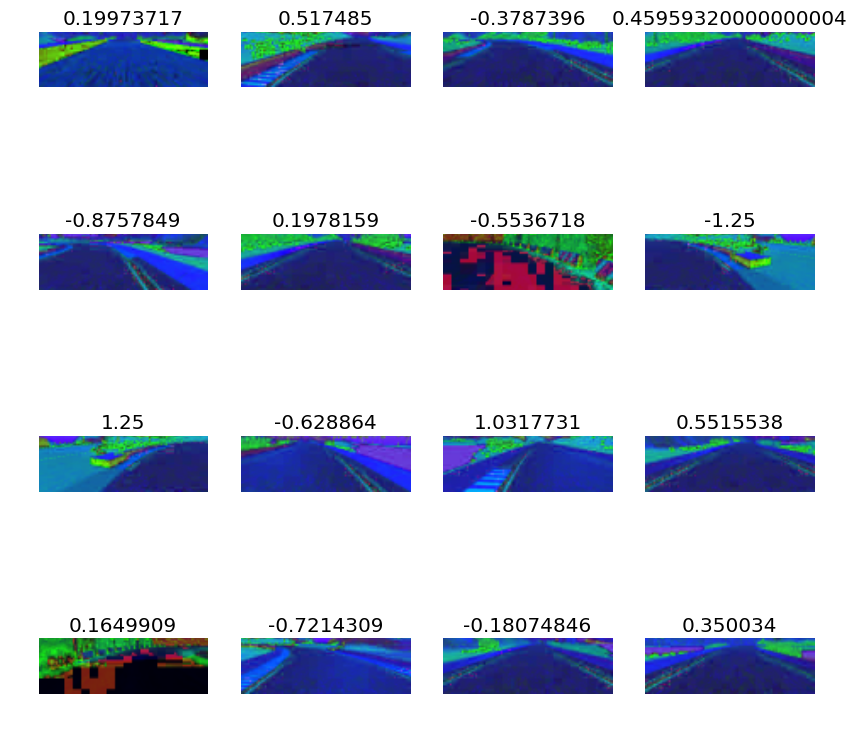

In [73]:
def hsv_image(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

for i in range(len(x_train)):
    img = hsv_image(x_train[i])
    x_train[i] = cv2.resize(img,(100,33),interpolation=cv2.INTER_AREA) 

x_len = len(x_train)
figure = plt.figure(figsize=(10,10))
factors = [4,4]
    
for ind in range(16):
    img = figure.add_subplot(factors[0],factors[1],ind + 1)
    i = random.randint(0,x_len)
    val = np.array(x_train[i])
    img.set_title(y_train[i])
    plt.axis("off")
    plt.imshow(val, cmap='gray')

# 2 split the valid data and the test data

In [74]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

x_train, y_train = shuffle(x_train, y_train)
x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)


#split the data to train and test
train_features, test_features, train_labels, test_labels = train_test_split(
    x_train,
    y_train,
    test_size=0.1,
    random_state=40)


#split the data to train and valid
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.2,
    random_state=11)

(67666, 33, 100, 3)


# 3 Architechture
I use Nivida modal which like that, which I changed to 'elu', and add 'dropout' layer to avoid overfit

In [75]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten,Dropout,Lambda
from keras.layers.convolutional import Convolution2D

model = Sequential()
model.add(Lambda(lambda x: x/255.-0.5, input_shape=(33,100,3),))
model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2,2)))
model.add(Activation('elu'))
model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2,2)))
model.add(Activation('elu'))
model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2,2)))
model.add(Activation('elu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('elu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('elu'))
model.add(Flatten())
model.add(Dense(1164))
model.add(Activation('elu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('elu'))
model.add(Dropout(0.5))

model.add(Dense(1,name='output'))
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_6 (Lambda)                (None, 33, 100, 3)    0           lambda_input_6[0][0]             
____________________________________________________________________________________________________
convolution2d_26 (Convolution2D) (None, 17, 50, 24)    1824        lambda_6[0][0]                   
____________________________________________________________________________________________________
activation_46 (Activation)       (None, 17, 50, 24)    0           convolution2d_26[0][0]           
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 9, 25, 36)     21636       activation_46[0][0]              
___________________________________________________________________________________________

# 4 run my CNN, use fit_generator 
use mse and adm to fit the dataset, modify the drive.py preprocess the image to apply the predict

In [76]:
from keras.optimizers import Adam
import json

model.compile(loss='mse',optimizer=Adam(lr=0.001),metrics=['accuracy'])

def generator(x_train,y_train,batch_size):
    len_train = len(train_features)
    while 1:        
        for offset in range(0, len_train, batch_size):
            yield x_train[offset:offset+batch_size],y_train[offset:offset+batch_size]

            
data_generator = generator_data(train_features, train_labels,1)
valid_generator = generator_data(valid_features, valid_labels,1)


history = model.fit_generator(generator(train_features, train_labels, 256), len(train_features), 
                              nb_epoch=4,validation_data=generator(valid_features, valid_labels, 256),
                              nb_val_samples = len(valid_features))


score = model.evaluate(test_features, test_labels, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

json_string = model.to_json()
model.save_weights('model.h5')
with open('model.json', 'w') as outfile:
	json.dump(model.to_json(), outfile)

Epoch 1/4
48719/48719 [==============================] - 210s - loss: 0.1560 - acc: 0.0095 - val_loss: 0.0820 - val_acc: 0.0118
Epoch 2/4
48719/48719 [==============================] - 191s - loss: 0.1022 - acc: 0.0107 - val_loss: nan - val_acc: nan
Epoch 3/4
48719/48719 [==============================] - 190s - loss: 0.0952 - acc: 0.0107 - val_loss: nan - val_acc: nan
Epoch 4/4
48719/48719 [==============================] - 202s - loss: 0.0901 - acc: 0.0111 - val_loss: nan - val_acc: nan
Test score: 0.0765922954029
Test accuracy: 0.0109354219004
